In [0]:
#%pip install databricks-feature-engineering
#%pip install codecarbon
#%pip install shap

## ML Ops Homework 2

**Disclaimer:** Chat GPT was used to support the completion of this assignment with:
1) supporting me on how to use the databricks platform
2) correcting small mistakes on the code

In [0]:
%restart_python

In [0]:
import pandas as pd
import numpy as np
import os
import tempfile
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from databricks.feature_store import FeatureStoreClient
from databricks import feature_store
from codecarbon import EmissionsTracker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import shap

import mlflow
import mlflow.sklearn

In [0]:
data = pd.read_csv("/Workspace/Users/bmedeiros@uchicago.edu/athletes.csv")
data.head()
     

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,465.0,NaN,1053.0,NaN,NaN,1081.0,205.0,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [0]:
# clean data and store original copy 
data_clean = data.copy()

# remove not relevant columns
data_clean = data_clean.dropna(subset=['region','age','weight','height','howlong','gender','eat', 
                                 'train','background','experience','schedule','howlong', 
                                 'deadlift','candj','snatch','backsq','experience',
                                 'background','schedule','howlong'])
data_clean = data_clean.drop(columns=['affiliate','team','name','fran','helen','grace',
                                'filthy50','fgonebad','run400','run5k','pullups','train'])

# remove Outliers
data_clean = data_clean[data_clean['weight'] < 1500]
data_clean = data_clean[data_clean['gender'] != '--']
data_clean = data_clean[data_clean['age'] >= 18]
data_clean = data_clean[(data_clean['height'] < 96) & (data_clean['height'] > 48)]

data_clean = data_clean[
    ((data_clean['gender'] == 'Male') & (data_clean['deadlift'] > 0) & (data_clean['deadlift'] <= 1105)) |
    ((data_clean['gender'] == 'Female') & (data_clean['deadlift'] > 0) & (data_clean['deadlift'] <= 636))
]
data_clean = data_clean[(data_clean['candj'] > 0) & (data_clean['candj'] <= 395)]
data_clean = data_clean[(data_clean['snatch'] > 0) & (data_clean['snatch'] <= 496)]
data_clean = data_clean[(data_clean['backsq'] > 0) & (data_clean['backsq'] <= 1069)]

# clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data_clean = data_clean.replace(decline_dict)
data_clean = data_clean.dropna(subset=['background','experience','schedule','howlong','eat'])

### Create new features
##### BMI

In [0]:

data_clean['BMI'] = (data_clean['weight'] * 703) / (data_clean['height'] ** 2)

##### "howlong" column in numeric formatting
- I noticed 571 rows have more than 1 option for 'howlong' (e.g., "Less than 6 months|1-2 years|" or "1-2 years|4+ years|")
- The new column "howlong_numeric" will not only clean out this noise, but will tranform it into a numeric value

In [0]:
data_clean['howlong'] = data_clean['howlong'].str.rstrip('|').str.strip()
data_clean = data_clean[~data_clean['howlong'].str.contains(r'\|', na=False)]

howlong_map = {
    "Less than 6 months": 0.5,
    "6-12 months": 1,
    "1-2 years": 1.5,
    "2-4 years": 3,
    "4+ years": 5
}
data_clean['howlong_numeric'] = data_clean['howlong'].map(howlong_map)

# Evalutation of new feature
print(f"COLUMN:\n{data_clean['howlong_numeric'].head(10)}\n")
print(f"UNIQUE VALUES: {data_clean['howlong_numeric'].unique()}\n")
print(f"VALUE COUNTS:\n{data_clean['howlong_numeric'].value_counts()}")
print("\nCompared to the original howlong column...\n")
print(f"UNIQUE VALUES ('howlong'):\n{data_clean['howlong'].value_counts()}\n")
print(f"\nNEW DATA SHAPE: {data_clean.shape}")

COLUMN:
21     1.5
22     3.0
27     3.0
50     1.5
60     5.0
78     1.0
101    5.0
102    3.0
103    5.0
110    3.0
Name: howlong_numeric, dtype: float64

UNIQUE VALUES: [1.5 3.  5.  1.  0.5]

VALUE COUNTS:
1.5    10415
3.0     9832
1.0     4014
5.0     3555
0.5     1628
Name: howlong_numeric, dtype: int64

Compared to the original howlong column...

UNIQUE VALUES ('howlong'):
1-2 years             10415
2-4 years              9832
6-12 months            4014
4+ years               3555
Less than 6 months     1628
Name: howlong, dtype: int64


NEW DATA SHAPE: (29444, 17)


In [0]:
# create target variable
data_clean['total_lift'] = (data_clean['deadlift'] + data_clean['candj'] + data_clean['snatch'] + data_clean['backsq'])

# one-hot encode gender and region
data_clean = pd.get_dummies(data_clean, columns=['gender'])
data_clean["gender_Female"] = data_clean["gender_Female"].astype("int32")
data_clean["gender_Male"] = data_clean["gender_Male"].astype("int32")

### Create Feature Tables & Data Versioning

In [0]:
# start Spark session
spark = SparkSession.builder.getOrCreate()

# convert df from pandas to Spark df
spark_df = spark.createDataFrame(data_clean)

In [0]:
# Version 1: basic features (keeping total_lift as target)
features_v1 = ["age", "height", "weight", "gender_Female", "gender_Male"]
data_v1 = data_clean[["athlete_id"] + features_v1 + ["total_lift"]].copy()

# Version 2: extended features (keeping total_lift as target)
features_v2 = features_v1 + ["BMI", "howlong_numeric"]
data_v2 = data_clean[["athlete_id"] + features_v2 + ["total_lift"]].copy()

# Now remove the data leakage columns (but keep total_lift for target)
data_leakage_cols = ['deadlift', 'candj', 'snatch', 'backsq', 'howlong']
unnecessary_columns = ['background', 'experience', 'schedule', 'eat', 'region']

# Remove leakage columns from the main dataframe for safety
data_clean = data_clean.drop(columns=data_leakage_cols + unnecessary_columns)

# convert to spark dataframes
spark_df_v1 = spark.createDataFrame(data_v1)
spark_df_v2 = spark.createDataFrame(data_v2)

In [0]:
# initialize Feature Store client
fs = FeatureStoreClient()

In [0]:
try:
    fs.drop_table("athletes_v1")
    fs.drop_table("athletes_v2")
    print("Dropped existing tables")
except:
    print("Tables didn't exist or couldn't be dropped")

# create feature tables
try:
    fs.create_table(
        name="athletes_v1",
        primary_keys=["athlete_id"],
        df=spark_df_v1,              
        description="Basic athlete features with demographics"
    )
    print("Created feature table: athletes_v1")
except Exception as e:
    print(f"Feature table athletes_v1 might already exist or error: {e}")

try:
    fs.create_table(
        name="athletes_v2",
        primary_keys=["athlete_id"],
        df=spark_df_v2,            
        description="Extended athlete features including BMI & howlong_numeric"
    )
    print("Created feature table: athletes_v2")
except Exception as e:
    print(f"Feature table athletes_v2 might already exist or error: {e}")

2025/07/17 19:33:21 WARNING databricks.ml_features._compute_client._compute_client: Deleting a feature table can lead to unexpected failures in upstream producers and downstream consumers (models, endpoints, and scheduled jobs).
2025/07/17 19:33:22 WARNING databricks.ml_features._compute_client._compute_client: Deleting a feature table can lead to unexpected failures in upstream producers and downstream consumers (models, endpoints, and scheduled jobs).


Dropped existing tables


2025/07/17 19:33:26 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['athlete_id'] of table 'workspace.default.athletes_v1' to NOT NULL.
2025/07/17 19:33:27 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['athlete_id'] on table 'workspace.default.athletes_v1'.
2025/07/17 19:33:33 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'workspace.default.athletes_v1'.


Created feature table: athletes_v1


2025/07/17 19:33:37 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['athlete_id'] of table 'workspace.default.athletes_v2' to NOT NULL.
2025/07/17 19:33:38 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['athlete_id'] on table 'workspace.default.athletes_v2'.
2025/07/17 19:33:44 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'workspace.default.athletes_v2'.


Created feature table: athletes_v2


### ML Pipeline

In [0]:
mlflow.set_experiment("/Users/bmedeiros@uchicago.edu/MLOps_HW2")

def train_pipeline(version: str, hyperparams: dict):
    # load feature table
    fs = FeatureStoreClient()
    pdf = fs.read_table(f"athletes_{version}").toPandas()

    # separate features/label
    X = pdf.drop(columns=["athlete_id", "total_lift"])
    y = pdf["total_lift"]

    # identify cat vs num
    cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    # build preprocessing + model pipeline
    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols)
    ])
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42, **hyperparams))
    ])

    # train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit & log under MLflow + codecarbon
    tracker = EmissionsTracker(project_name="MLOps_Assignment_2")
    tracker.start()
    
    hyperparams_str = f"n{hyperparams['n_estimators']}_d{hyperparams['max_depth']}"
    run_name = f"rf_{version}_{hyperparams_str}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(hyperparams)
        mlflow.log_param("feature_version", version)
        
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_te)
        
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        r2 = r2_score(y_te, y_pred)
        
        emissions = tracker.stop()
        
        mlflow.log_metrics({"rmse": rmse, "r2": r2, "carbon_emissions_kg": emissions})
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"\nResults for {version} | {hyperparams}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R² : {r2:.4f}")
        print(f"  CO₂ : {emissions:.6f} kg")

        # SHAP plot
        try:
            explainer = shap.TreeExplainer(pipeline.named_steps["regressor"])
            X_trans = pipeline.named_steps["preprocessor"].transform(X_te)
            feat_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
            shap_vals = explainer.shap_values(X_trans)

            # Calculate and print feature importance ranking
            feature_importance = np.abs(shap_vals).mean(axis=0)
            importance_df = pd.DataFrame({
                'feature': feat_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)
            
            print(f"\nFeature Importance Ranking for {version}:")
            for i, row in importance_df.iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")

            with tempfile.TemporaryDirectory() as td:
                fname = os.path.join(td, f"shap_{version}.png")
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_vals, X_trans, feature_names=feat_names, show=False)
                plt.title(f"SHAP Summary Plot - Version {version.upper()}, Params: {hyperparams}", 
                 fontsize=14, pad=20)
                plt.tight_layout()
                plt.savefig(fname)
                mlflow.log_artifact(fname)
                plt.show()
        except Exception as e:
            print(f"SHAP plot error: {e}")

    return {"version": version, "rmse": rmse, "r2": r2, "carbon_emissions_kg": emissions}



=== TRAINING v1 with {'n_estimators': 100, 'max_depth': 3} ===


[codecarbon WARNING @ 19:33:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 19:33:48] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 19:33:48] [setup] RAM Tracking...
[codecarbon INFO @ 19:33:48] [setup] CPU Tracking...
[codecarbon WARNING @ 19:33:48] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 19:33:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 19:33:48] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 19:33:48] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 19:33:49] [setup] GPU Tracking...
[codecarbon INFO @ 19:33:49] No GPU found.
[codecarbon INFO @ 19:33:49] The 


Results for v1 | {'n_estimators': 100, 'max_depth': 3}
  RMSE: 176.6594
  R² : 0.5892
  CO₂ : 0.000048 kg

Feature Importance Ranking for v1:
  num__gender_Female: 87.0332
  num__gender_Male: 73.8969
  num__weight: 55.1271
  num__age: 30.3400
  num__height: 0.0108


/home/spark-a93c7cc0-818b-41b5-a27e-f8/.ipykernel/55905/command-5484539137413087-1728810906:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


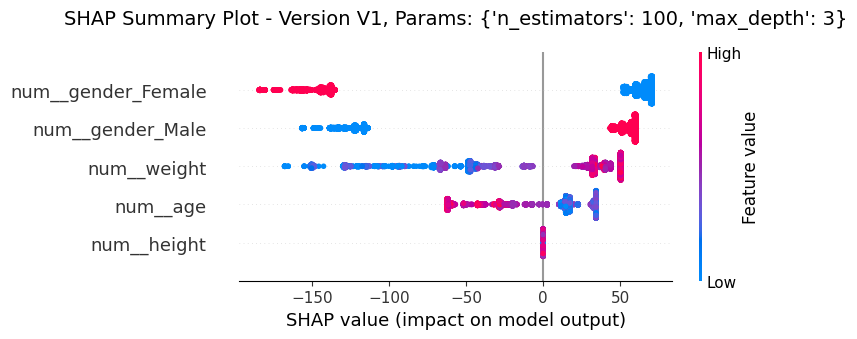


=== TRAINING v1 with {'n_estimators': 200, 'max_depth': 5} ===


[codecarbon WARNING @ 19:34:06] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 19:34:06] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 19:34:06] [setup] RAM Tracking...
[codecarbon INFO @ 19:34:06] [setup] CPU Tracking...
[codecarbon WARNING @ 19:34:07] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 19:34:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 19:34:07] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 19:34:07] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 19:34:07] [setup] GPU Tracking...
[codecarbon INFO @ 19:34:07] No GPU found.
[codecarbon INFO @ 19:34:07] The 


Results for v1 | {'n_estimators': 200, 'max_depth': 5}
  RMSE: 170.4895
  R² : 0.6173
  CO₂ : 0.000023 kg

Feature Importance Ranking for v1:
  num__gender_Female: 78.5767
  num__gender_Male: 78.5410
  num__weight: 62.7203
  num__age: 38.4666
  num__height: 10.3304


/home/spark-a93c7cc0-818b-41b5-a27e-f8/.ipykernel/55905/command-5484539137413087-1728810906:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


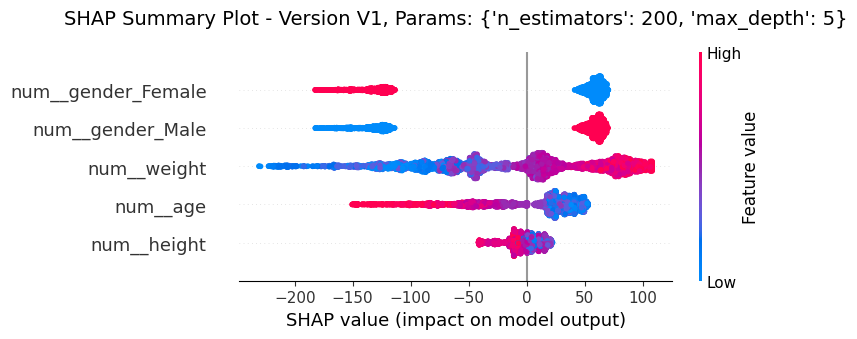


=== TRAINING v2 with {'n_estimators': 100, 'max_depth': 3} ===


[codecarbon WARNING @ 19:34:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 19:34:22] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 19:34:22] [setup] RAM Tracking...
[codecarbon INFO @ 19:34:22] [setup] CPU Tracking...
[codecarbon WARNING @ 19:34:22] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 19:34:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 19:34:22] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 19:34:22] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 19:34:22] [setup] GPU Tracking...
[codecarbon INFO @ 19:34:22] No GPU found.
[codecarbon INFO @ 19:34:22] The 


Results for v2 | {'n_estimators': 100, 'max_depth': 3}
  RMSE: 172.4885
  R² : 0.6066
  CO₂ : 0.000011 kg

Feature Importance Ranking for v2:
  num__gender_Female: 84.8024
  num__gender_Male: 81.3998
  num__BMI: 59.7800
  num__age: 26.4088
  num__howlong_numeric: 7.6229
  num__weight: 3.9369
  num__height: 0.0000


/home/spark-a93c7cc0-818b-41b5-a27e-f8/.ipykernel/55905/command-5484539137413087-1728810906:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


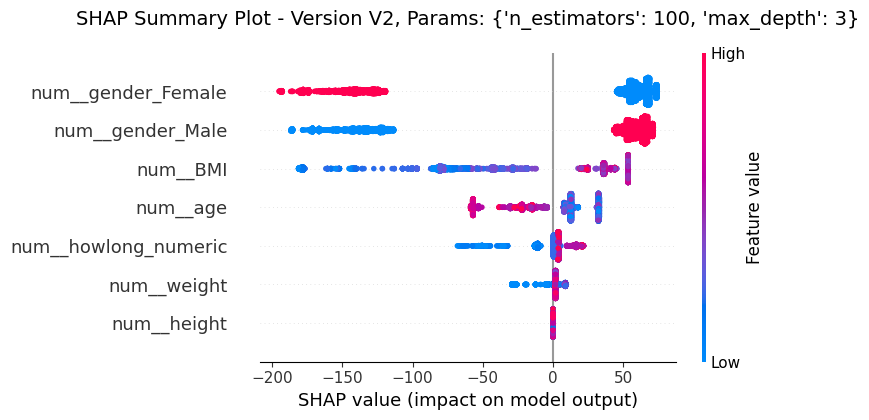


=== TRAINING v2 with {'n_estimators': 200, 'max_depth': 5} ===


[codecarbon WARNING @ 19:34:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 19:34:34] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 19:34:34] [setup] RAM Tracking...
[codecarbon INFO @ 19:34:34] [setup] CPU Tracking...
[codecarbon WARNING @ 19:34:34] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 19:34:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 19:34:34] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 19:34:34] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 19:34:34] [setup] GPU Tracking...
[codecarbon INFO @ 19:34:34] No GPU found.
[codecarbon INFO @ 19:34:34] The 


Results for v2 | {'n_estimators': 200, 'max_depth': 5}
  RMSE: 161.6036
  R² : 0.6547
  CO₂ : 0.000000 kg

Feature Importance Ranking for v2:
  num__gender_Female: 82.8804
  num__gender_Male: 81.1204
  num__BMI: 58.6336
  num__age: 40.9955
  num__howlong_numeric: 39.0225
  num__weight: 9.2449
  num__height: 0.4088


/home/spark-a93c7cc0-818b-41b5-a27e-f8/.ipykernel/55905/command-5484539137413087-1728810906:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


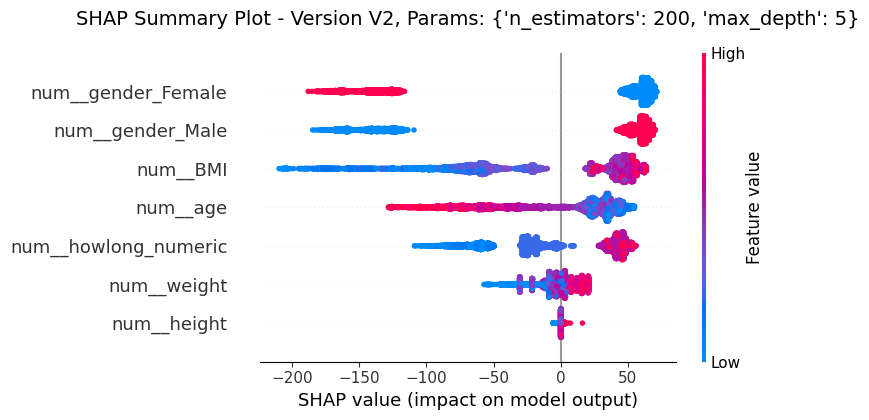

In [0]:
# run across both versions and two hyperparam sets
params1 = {"n_estimators": 100, "max_depth": 3}
params2 = {"n_estimators": 200, "max_depth": 5}
results = []

for ver in ["v1", "v2"]:
    for p in [params1, params2]:
        print(f"\n=== TRAINING {ver} with {p} ===")
        results.append(train_pipeline(ver, p))

In [0]:
# results table 
params_list = [params1, params2] 
table_data = []
for i, res in enumerate(results):
    params = params_list[i % 2]  
    table_data.append({
        "Version": res["version"],
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "RMSE": res["rmse"],
        "R²": res["r2"],
        "CO2 Emissions (kg)": res["carbon_emissions_kg"],
    })
df_results = pd.DataFrame(table_data)
display(df_results)

# Comparison analysis
print("\n=== ANALYSIS ===")
print("Best R² Score:")
best_r2 = df_results.loc[df_results['R²'].idxmax()]
print(f"  Version: {best_r2['Version']}, R²: {best_r2['R²']:.4f}, RMSE: {best_r2['RMSE']:.4f}")

print("\nLowest RMSE:")
best_rmse = df_results.loc[df_results['RMSE'].idxmin()]
print(f"  Version: {best_rmse['Version']}, RMSE: {best_rmse['RMSE']:.4f}, R²: {best_rmse['R²']:.4f}")

print("\nLowest Carbon Emissions:")
best_carbon = df_results.loc[df_results['CO2 Emissions (kg)'].idxmin()]
print(f"  Version: {best_carbon['Version']}, Carbon: {best_carbon['CO2 Emissions (kg)']:.6f} kg")

print("\nAverage performance by Version:")
print(df_results.groupby('Version')[['RMSE', 'R²', 'CO2 Emissions (kg)']].mean())

Version,n_estimators,max_depth,RMSE,R²,CO2 Emissions (kg)
v1,100,3,176.65944108208103,0.5891516130167851,4.81249407933747E-5
v1,200,5,170.48949403017363,0.6173487592474992,2.2642052759044496E-5
v2,100,3,172.48854983874236,0.6065666310370559,1.129946487240313E-5
v2,200,5,161.60363861252782,0.6546552010184636,1.4190011497995143E-7



=== ANALYSIS ===
Best R² Score:
  Version: v2, R²: 0.6547, RMSE: 161.6036

Lowest RMSE:
  Version: v2, RMSE: 161.6036, R²: 0.6547

Lowest Carbon Emissions:
  Version: v2, Carbon: 0.000000 kg

Average performance by Version:
               RMSE        R²  CO2 Emissions (kg)
Version                                          
v1       173.574468  0.603250            0.000035
v2       167.046094  0.630611            0.000006


#### Quantitative Analysis
There was a slight improvement in v2 (models 3 and 4) after the feature engineering. This is noticeable in both the RMSE (`176.65` -> `172.48` & `170.49` -> `161.60`) and R-squared (`0.59` -> `0.61` & `0.62` -> `0.65`). Interestingly, CO2 emissions increased for both models with data version 2 (v2). The best performing model was v2 with `n_estimators = 200` and `max_depth = 5`.

#### Qualitative Analysis
**Gender:**
- Independent of data versioning, `gender` remains as the most important feature. 
- Across all four runs, `female` is to the left and `male` is to the right, which indicates that the model is subtracting lift when it sees `female` and adding lift when seeing `male`—which is expected. 

**BMI/Weight/Height:**
- Interestingly, though, for data version 2, where we introduced `BMI`, we can see that `weight`, which was of high feature importance, get overshadowed by `BMI`. This shoes that `BMI` is a better predictor than `weight` alone. 
- `height` remains of low feature importance in all data and hyperparameter versions.

**howlong_numerical/Age:**
- `howlong_numerical` value has, surprisingly, low feature importance. But, it is reasonable in saying that, the higher the value is for the `howlong_numerical` (i.e., the longer you have been training for), the higher your `total lift` should be. 
- What is surprising, though, is `age`. Not only does it also not have very high feature importance, but its behavior is opposite from `howlong_numerical`. Therefore, the older you are, the the less you lift. 

#### Quick indictator on how to intepret the graphs
- Each row = a feature (like age, weight, BMI)
- Each dot = one person (one athlete in your dataset)
- Each dot's position = how much that feature changed the prediction for that person
- Each dot’s color = did this person have a high or low value for this feature?